In [62]:
import rasterio
import cv2 as cv
import numpy as np

image_path = 'data/batch_001/8928dec4ddbffff/DJI_0876.JPG'
# Open the image and read the bands as numpy arrays
with rasterio.open(image_path) as src:
    blue = src.read(1)
    green = src.read(2)
    red = src.read(3)

import numpy as np
# Allow division by zero
np.seterr(divide='ignore', invalid='ignore')

# Stack the bands to create a color image
rgb = np.dstack((blue, green, red))

vari = (green.astype(float) - red.astype(float)) / (
    green.astype(float) + red.astype(float) - blue.astype(float))

# Min and max values for the VARI index
vari_min = 0.1
vari_max = 0.5

# Generate the vegetation mask
vegetation_mask = np.full(vari.shape, np.nan)
vegetation_mask[(vari >= vari_min)] = 1

# Generate the non-vegetation mask
non_vegetation_mask = np.full(vari.shape, np.nan)
non_vegetation_mask[vari < vari_min] = 1


/Users/kevinlacaille/.pyenv/versions/3.11.4/envs/scipy2024-env/lib/python3.11/site-packages/rasterio/__init__.py:304: NotGeoreferencedWarning: Dataset has no geotransform, gcps, or rpcs. The identity matrix will be returned.
  dataset = DatasetReader(path, driver=driver, sharing=sharing, **kwargs)


In [63]:
gsd = 0.028712994791666672  # meters per pixel
diameter_of_tree = 10  # meters
kernel_size = int(np.sqrt(diameter_of_tree / gsd))  # square kernel size
print("Kernel size: ", kernel_size, "pixels")


Kernel size:  18 pixels


In [64]:
# Apply a Gaussian blur to the vegetation mask
blur = cv.GaussianBlur(vegetation_mask, (7, 7), 0)

opening_kernel = np.ones((kernel_size, kernel_size), np.uint8)

opening = cv.morphologyEx(blur, cv.MORPH_OPEN, opening_kernel)

closing_kernel = np.ones((kernel_size, kernel_size), np.uint8)

closing = cv.morphologyEx(opening, cv.MORPH_CLOSE, closing_kernel)

In [65]:
# Create a mask overlay with purple color (Red + Blue)
mask_overlay = np.zeros_like(rgb)
mask_overlay[:, :, 0] = 128  # Red channel for purple
mask_overlay[:, :, 1] = 0  # Green channel for purple
mask_overlay[:, :, 2] = 128  # Blue channel for purple

# Apply the filtered mask to the mask overlay
mask_overlay[closing != 1] = [0, 0, 0]  # Transparent where mask is not applied


In [66]:
# Create the inverse mask
inverse_closing = np.logical_not(closing).astype(np.uint8)

# Create an inverse mask overlay with purple color
inverse_mask_overlay = np.zeros_like(rgb)
inverse_mask_overlay[:, :, 0] = 128  # Red channel for purple
inverse_mask_overlay[:, :, 1] = 0  # Green channel for purple
inverse_mask_overlay[:, :, 2] = 128  # Blue channel for purple

# Apply the inverse mask to the inverse mask overlay
inverse_mask_overlay[closing == 1] = [
    0, 0, 0
]  # Transparent where original mask is applied


In [67]:
import matplotlib.pyplot as plt

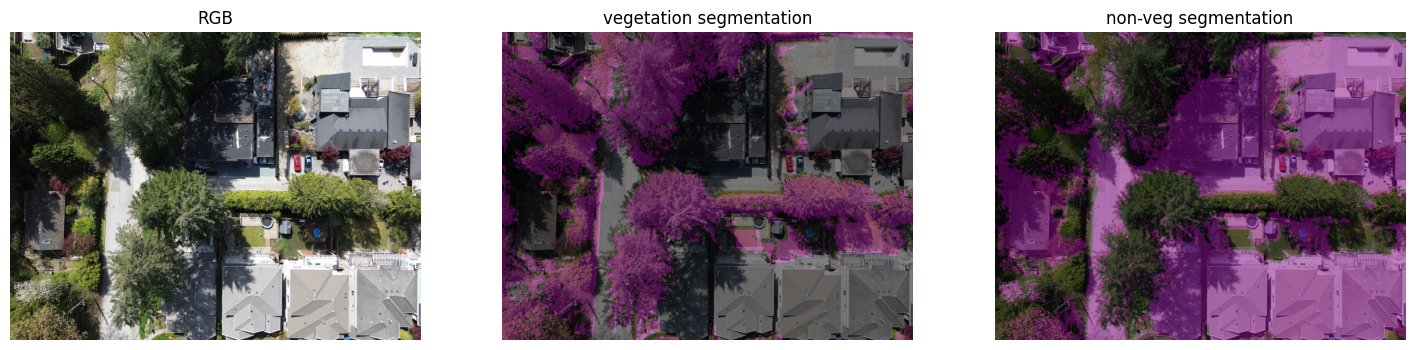

In [68]:
fig, ax = plt.subplots(1, 3, figsize=(18, 6))

plt.sca(ax[0])
plt.imshow(rgb)
plt.axis('off')
plt.title('RGB')

plt.sca(ax[1])
plt.imshow(rgb)
plt.imshow(mask_overlay, alpha=0.5)
plt.axis('off')
plt.title('vegetation segmentation')

plt.sca(ax[2])
plt.imshow(rgb)
plt.imshow(inverse_mask_overlay, alpha=0.5)
plt.axis('off')
plt.title('non-veg segmentation')

plt.show()